# Cluster Membership Probability
# Page 2

# Introduction

We use RGEO insteag of parallax.

In this section we aim to assign cluster membership probabilities for a selected open cluster using Extreme Convolution Gaussian Mixture Models. These models allow us to use any data available as they can account for measurement error and missing values. We now want to look at using RGEO as our distance estimate in order to better classify.

Lindegren et al needs to be done

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [2]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)         

# Astrometric solution With RGEO

We begin by analysing a purely astrometric solution. We do this as we expect our open cluster to appear as a strong overdensity in astrometric space and so we hope GMM will be a useful model for assigning cluster probabilities.

# 1.5 Import Data From CSV

In [3]:
os.chdir('../cluster_files')

In [4]:
gaia_eso=pd.read_csv('gaia_eso.csv')
gaia_not_eso=pd.read_csv('gaia_not_eso.csv')

In [5]:
os.chdir('../Cluster_analysis')

We create two dataframes, one with all of the GAIA ESO values and another which comes from GAIA only.

In [6]:
gaia_eso.dropna(subset='radial_velocity')[['radial_velocity','VRAD']]
gaia_not_eso['radial_velocity']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
128530   NaN
128531   NaN
128532   NaN
128533   NaN
128534   NaN
Name: radial_velocity, Length: 128535, dtype: float64

# 1.6.1 Global corections

Remove G>18
What about the parallax zero point?

https://arxiv.org/pdf/2108.02783.pdf

The effectiveness of our model will depend on the data we use. Gaia eDR3 has a 5 astormetric solution. We use the recommendations from 294 Lindegren et al. (2018) to account for systematics found 295 within the parallax and proper-motion data. In par- 296 ticular, we subtract the -0.029 mas parallax zero-point 297 from all of our stars and exclude all stars fainter than 298 18th Gaia G magnitude.

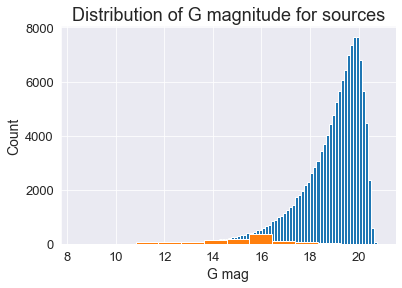

In [7]:
plt.hist(gaia_not_eso['phot_g_mean_mag'],bins=100,label='Gaia not eso')
plt.hist(gaia_eso['phot_g_mean_mag'],bins=10,label='GAIA ESO')
plt.xlabel('G mag')
plt.ylabel('Count')
plt.title('Distribution of G magnitude for sources')
plt.show()

In [8]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['phot_g_mean_mag']<=18.0].reset_index(drop=True)
gaia_eso=gaia_eso[gaia_eso['phot_g_mean_mag']<=18.0].reset_index(drop=True)

In [9]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['visibility_periods_used']>5].reset_index(drop=True)
gaia_eso=gaia_eso[gaia_eso['visibility_periods_used']>5].reset_index(drop=True)

We make cuts in proper motion space and parallax space as we expect cluster members to be in a high overdesnity in parameter space. We make a 3 sigma clip from the median.

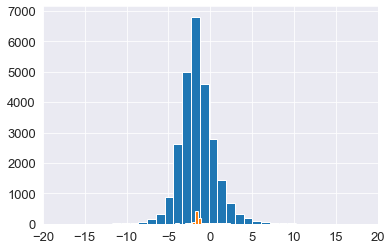

In [10]:
plt.hist(gaia_not_eso['pmra'],bins=100)
plt.hist(gaia_eso['pmra'],bins=50)
plt.xlim(-20,20)
plt.show()

 Make a 3 sigma clip on proper motion

In [11]:
bound=[gaia_eso['pm'].median()-3*gaia_eso['pm'].std(),gaia_eso['pm'].median()+3*gaia_eso['pm'].std()]

In [12]:
truth1=gaia_not_eso['pm']>=bound[0]

gaia_not_eso=gaia_not_eso[truth1].reset_index(drop=True)
truth2=gaia_not_eso['pm']<=bound[1]
gaia_not_eso=gaia_not_eso[truth2].reset_index(drop=True)
len(gaia_not_eso)

25197

In [13]:
truth1=gaia_eso['pm']>=bound[0]

gaia_eso=gaia_eso[truth1].reset_index(drop=True)
truth2=gaia_eso['pm']<=bound[1]
gaia_eso=gaia_eso[truth2].reset_index(drop=True)
len(gaia_eso)

984

# 1.6 Make a parallax cut 

In order to make a cut on parallax we are going to use the median and standard deviation from the GAIA ESO sample to make our cuts on the overall sample.

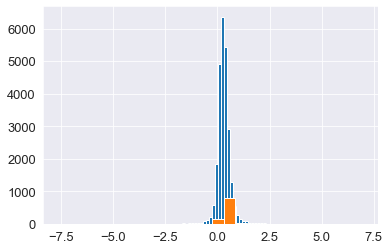

In [14]:
plt.hist(gaia_not_eso['parallax'],bins=100)
plt.hist(gaia_eso['parallax'],bins=15)
plt.show()

In [15]:
np.std(gaia_eso['parallax'])

0.36496830616464826

In [16]:
bound=[gaia_eso['parallax'].median()-3*gaia_eso['parallax'].std(),gaia_eso['parallax'].median()+3*gaia_eso['parallax'].std()]

In [17]:
truth1=gaia_not_eso['parallax']>=bound[0]
gaia_not_eso=gaia_not_eso[truth1].reset_index(drop=True)
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth2].reset_index(drop=True)
len(gaia_not_eso)

24858

In [18]:
truth1=gaia_eso['parallax']>=bound[0]
gaia_eso=gaia_eso[truth1].reset_index(drop=True)
truth2=gaia_eso['parallax']<=bound[1]
gaia_eso=gaia_eso[truth2].reset_index(drop=True)
len(gaia_eso)

974

In [19]:
gaia_not_eso['parallax'].min()

-0.6881985653324588

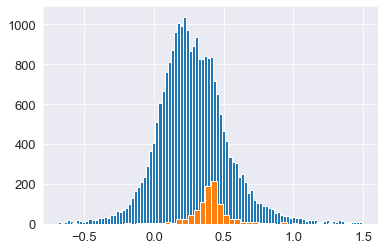

In [20]:
plt.hist(gaia_not_eso['parallax'],bins=100)
plt.hist(gaia_eso['parallax'],bins=50)
plt.show()

# 1.7 Making Data into Learning Format.

In [21]:
columns_parameters=['ra','dec','rgeo','VRAD','pmra','pmdec']

In [22]:
gaia_eso=gaia_eso[gaia_eso.replace('nan',0.0).fillna(0.0)['VRAD'].astype(float)<=300]



In [23]:
data=pd.concat([gaia_eso, gaia_not_eso])

In [24]:
data.VRAD=data.VRAD.fillna(data.radial_velocity)
data.E_VRAD=data.E_VRAD.fillna(data.radial_velocity_error)

In [25]:
input_cluster_data=data[columns_parameters]

input_cluster_data['rgeo']=input_cluster_data['rgeo'].values/1000.0


/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_18432/2853244238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_cluster_data['rgeo']=input_cluster_data['rgeo'].values/1000.0


In [26]:
from scipy.stats import gaussian_kde
hue = np.vstack([input_cluster_data['rgeo'],input_cluster_data['ra'],input_cluster_data['dec']])
hue = gaussian_kde(hue)(hue)
#input_cluster_data['hue']=hue

import plotly.express as px
plt.figure(figsize=(15,15))
df = input_cluster_data
fig = px.scatter_3d(df, x='ra', y='dec', z='rgeo',color='hue')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20)
)
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['ra', 'dec', 'rgeo', 'VRAD', 'pmra', 'pmdec'] but received: hue

<Figure size 1080x1080 with 0 Axes>

# Merge the radial velocities

In [27]:
input_cluster_data.columns

Index(['ra', 'dec', 'rgeo', 'VRAD', 'pmra', 'pmdec'], dtype='object')

When we analyse the parameters of the sample along the line of sight we see very strong peaks in velocity space. This is to be expected in an open cluster. We also expect the stars to be at the same distane, however we have no clear indication by eye to this by the parallax diagram, except perhaps the two close peaks. We investigate this further by looking at the Bailer Jones posterior estimates for the distance.

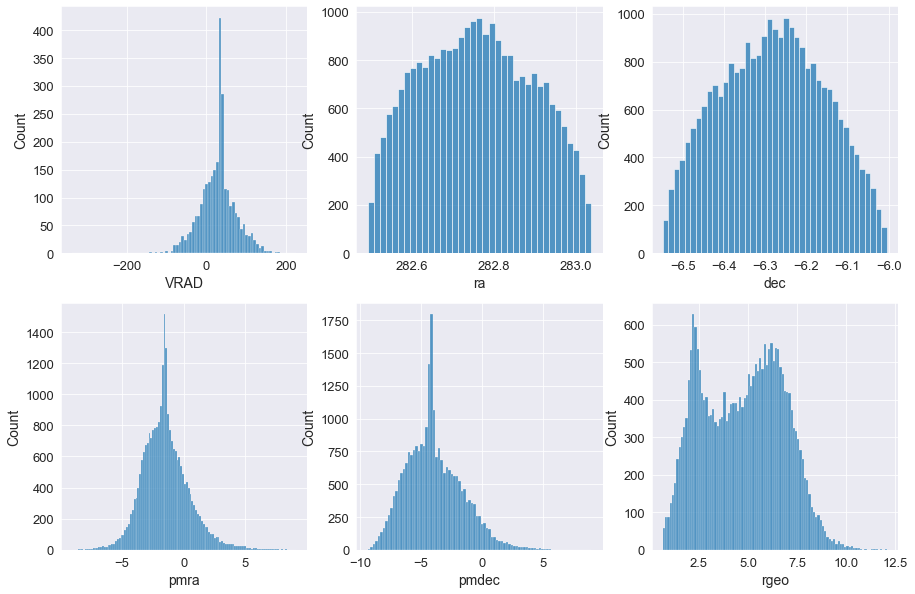

In [28]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.histplot(data=input_cluster_data['VRAD'],ax=axs[0,0])
sn.histplot(data=input_cluster_data['ra'],ax=axs[0,1])
sn.histplot(data=input_cluster_data['dec'],ax=axs[0,2])
sn.histplot(data=input_cluster_data['pmra'],ax=axs[1,0])
sn.histplot(data=input_cluster_data['pmdec'],ax=axs[1,1])
sn.histplot(data=input_cluster_data['rgeo'],ax=axs[1,2],bins=100)
plt.show()


Looking at the Bailer Jones posterior estimates for the distance shows us a more clear cut isolated peak, which may correspond to our cluster.

In [29]:
x=input_cluster_data[['rgeo','pmra']].values

Here we see that the strong correlation in proper motion space is not very strong in the relationship between distance and proper motion

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

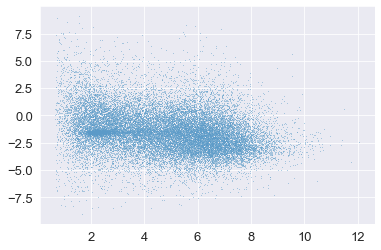

In [30]:
sn.scatterplot(x.transpose()[0],x.transpose()[1],s=0.5)

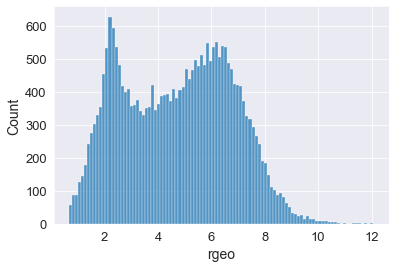

In [31]:
sn.histplot(data=input_cluster_data['rgeo'],bins=100)
plt.xlim()
plt.show()

Error call in

In [32]:
columns_error=['ra_error','dec_error','E_VRAD','b_rgeo','B_rgeo','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([gaia_eso, gaia_not_eso])[columns_error]

In [33]:
error_input['B_rgeo']=error_input['B_rgeo']/1000.0
error_input['b_rgeo']=error_input['b_rgeo']/1000.0

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)


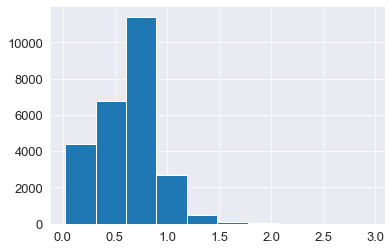

In [35]:
plt.hist((error_input['B_rgeo']-error_input['b_rgeo'])*1/input_cluster_data['rgeo'])
plt.show()

# Covariance Error matrix

Our covariance error matrix is built up using the errors and correlations (if available). Correlations are available for the Gaia 5 dimensinonal astrometric solution, however the correlation for the radial velocity to other variables is not known so we will let it be zero.

In [36]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=0.0
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=0.0
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=(0.01*(error_input['B_rgeo']-error_input['b_rgeo'])*1/input_cluster_data['rgeo']).to_numpy()#0.5
s[:,2,3]=0.0
s[:,2,4]=0.00
s[:,2,5]=0.00

s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix R 

In order to unitilise the XDGMM we introduce a mixing matrix for each datapoint. That is, we want a matrix $R_i$ such that given an observation with missing values $w_i$ the true observation can be modelled as $w_i=R_ix_i$. Our form of the matrix is very simple, a diagonal matrix with $1$ along the $n^{th}$ diagonal if the $n^{th}$ feature was measured, and $0$ if not measured.

In [37]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [38]:
mixing_prep[1000]

array([1, 1, 1, 0, 1, 1])

In [39]:


R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)
R.shape

(25832, 6, 6)

In [40]:
learning_R=R

# Definitions of the learning inputs

In [41]:
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001) #this is so not to get singular matrix


# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf
Extreme Deconvolution GMM

In this section I'm following the above paper which adapts the GMM to noisy and missing data. I only apply this to the Gaia eso data at first, and using astrometric data.

Using Bayes Law:
$$ P(C | D)= P(D|C)P(C)\over{P(D)}$$
Let $\textbf{w}_{i}$ be the vector of observed data, and $\textbf{x}_i$ be the vector of 'true' values. Let $R$ be the matrix which projects $\textbf{x}_i$ to $\textbf{w}_i$ and let $S_i$ be a known covariance matrix, so that we assume $$\textbf{w}_i=R_i\textbf{x}_i + \text{noise}$$ where the noise is drawn from a Gaussian distribution with mean 0 and covariance $S_i$

Letting $\theta=(\alpha_j,\mu_j,V_j)$ be the parameters for a Gaussian mixture model. Following the paper above we can show that the likelihood of $\textbf{w}_i$ in terms of $\theta$ is the Gaussian mixture model: $$p(\textbf{w}_i|\theta)=\sum_j \alpha_j N(\textbf{w}_i|R_i\mu_j,T_{ij})$$
where $$T_{ij}=R_iV_jR_i^t+S_i$$

In [42]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Cluster_analysis')

We fit as per the above paper and use their E-M update algorithm. GMM returns the maximum likelihood values for the gaussian mixture parameters.

One part uses all the GES data and other uses both Gaia eso and gaia.

# Fit

We now fit our XDGMM to our data in order to assign membership probabilities. We fit our model to the data in two different ways. The first is to fit the model only to the GAIA Eso model and then evaluate the probabilities on the rest of the dataset. Our second is training our model on the full dataset and then evaluating the prbabilities simulataneously.

We use a two step process to find the best number of components in our XDGMM, we fit for numerous number of components and then evaluate the BIC. The next step is to manually check to see if the model has captured the key dependencies in velocity space. We then choose the model with the highest BIC which captures the overdensity in velocity space.

We first fit our model to the GAIA ESO data.

In [43]:
gmm_GES=XDGMM(2).fit(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])


gmm
endgmm


In [44]:
gmm_full=XDGMM(4).fit(learning_input,Xerr=learning_error_covariance,R=R)

gmm
endgmm


# This is where this goes into the file......

# ==========================================================================================

# Evaluating the Joint Probability $P(z,\textbf{w}_i)$

Let $z \in \{0,...,k\}$ be the random variable of deciding the probability of belonging to a component of the Gaussian Mixture.   
We have $$p(z,\textbf{w}_k|\theta)=p(z)p(\textbf{w}_k|z,\theta)$$
We can then find the posterior density function for $z$: $$p(z=i|\textbf{w}_k,\theta)={p(z=i|\theta)p(\textbf{w}_k|z=i,\theta)\over \sum_j p(z=j|\theta)p(\textbf{w}_k|z=j,\theta)}$$


The prior is $p(z=i|\theta)=\alpha_i$. This is the posterior probability that an observation has been generated from the $i^{th}$ component

# GAIA ESO Train and evaluate.

### We first consider when the model was trained only on GAIA ESO data.

In [45]:

prob_ges=gmm_GES.prob_z_given_w(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

We plot the parameter space, darker dots correspond to higher probability of assignment.

In [46]:
df=pd.DataFrame(learning_input[0:len(gaia_eso)],columns=columns_parameters)
df2=pd.DataFrame(prob_ges[:,1][0:len(gaia_eso)],columns=['prob'])
plot_df_ges=pd.concat([df,df2],axis=1)

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

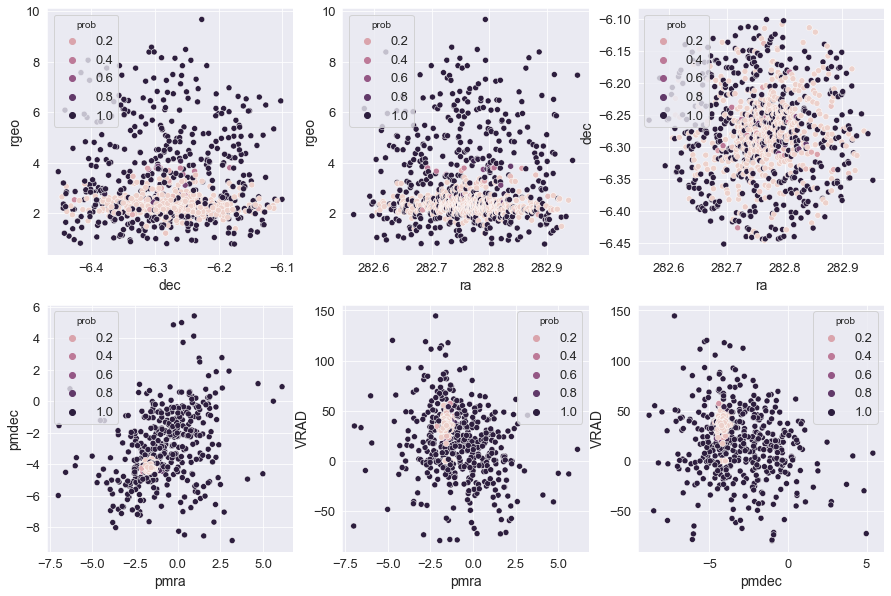

In [47]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_ges,x='dec',y='rgeo',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_ges,x='ra',y='rgeo',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_ges,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_ges,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_ges,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_ges,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# GAIA ESO + GAIA

We now train a different model on the whole of the dataset.

In [48]:

prob_full=gmm_full.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)

We look for the component with the high velocity space overdensity.

In [61]:
prob_index=2

In [62]:
df2=pd.DataFrame(prob_full[:,prob_index],columns=['prob'])
plot_df_full=pd.concat([df,df2],axis=1)

GAIA ESO AND GAIA parameter distribution

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

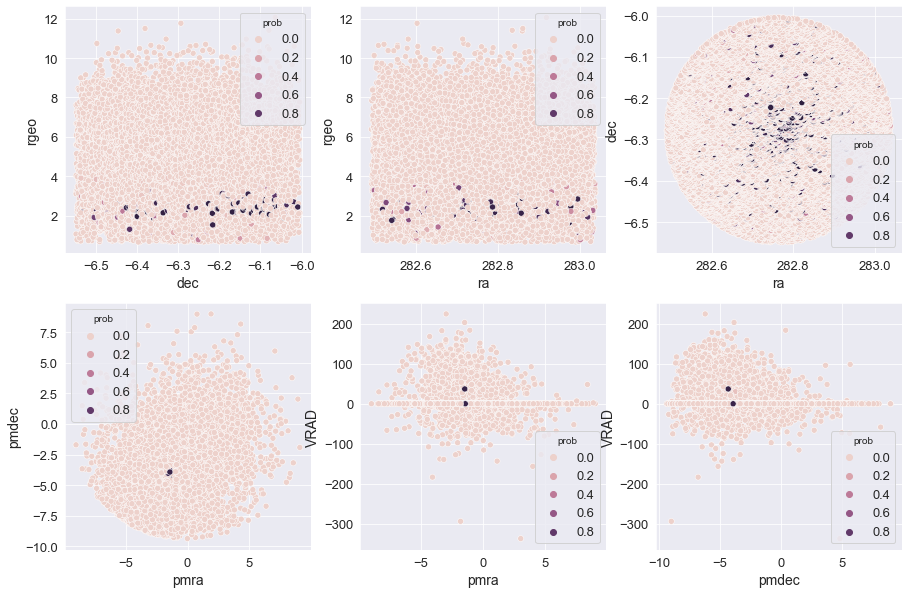

In [63]:

fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_full,x='dec',y='rgeo',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_full,x='ra',y='rgeo',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_full,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_full,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_full,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_full,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])


# Rgeo Comments
Here we can see that we are getting similar results to when we used the parallax, in order to fully evaluate we want to look at the distribution of parameters.

# 2.2 Train on Gaia ESO and evaluate on GAIA plus GAIA ESO

We now see what happens if we train on a 'good' sample, that being the GAIA ESO and then apply to a much larger data set, with also less information attached to it.

In [64]:

comp=gmm_GES.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(comp[:,1],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)

Now we see this evaluated on our full dataset.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

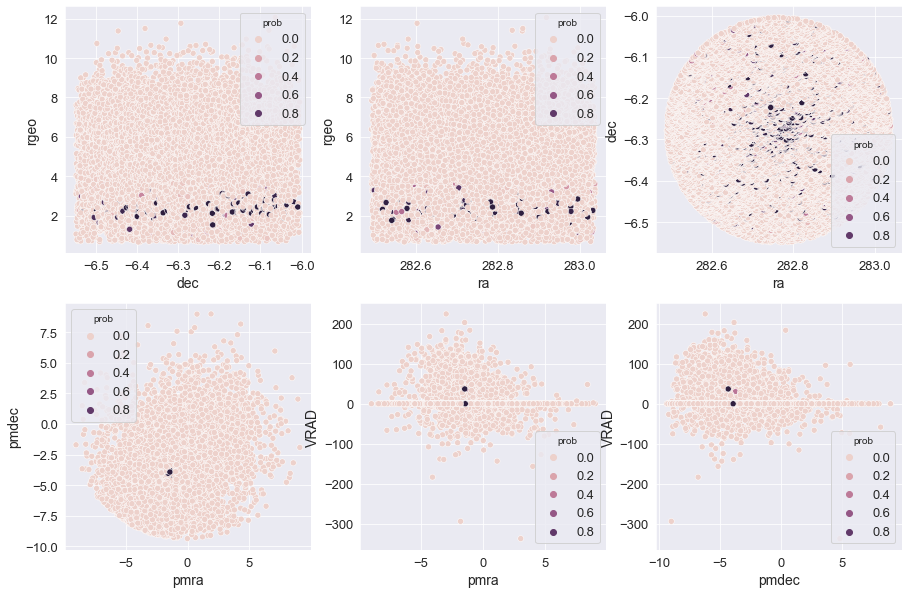

In [65]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='rgeo',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='rgeo',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

Now we evaluate it only on the GAIA data

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

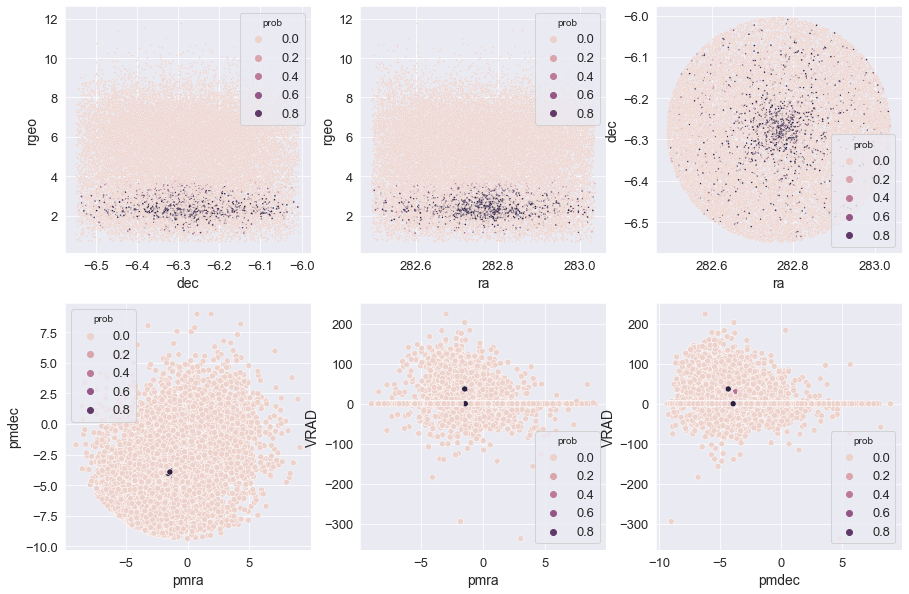

In [66]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='dec',y='rgeo',hue='prob',ax=axs[0,0],s=3)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='rgeo',hue='prob',ax=axs[0,1],s=3)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='dec',hue='prob',ax=axs[0,2],s=3)

sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# Colour Magnitude Diagrams and Futher Analysis

## Here we are going to analyse the HR diagrams

As per recommended: We also exclude all stars with $gaiadr2.phot bp rp excess factor  >1.5+0.03·(GBP - GRP )^2$ , as it is a sign of serious colour systematic errors.

https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf

In [67]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo']*1000)+5
    return selection_gaia

def mean_basolute_mag_g_band_parallax(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band_p']=selection_gaia['phot_g_mean_mag']+5*np.log10(selection_gaia['parallax']*0.001)+5
    return selection_gaia

In [68]:
df_diagram=pd.concat([plot_df.reset_index(),data.reset_index()],axis=1)
df_diagram_full=pd.concat([plot_df_full.reset_index(),data.reset_index()],axis=1)

In [69]:
df_diagram_full = df_diagram_full.loc[:,~df_diagram_full.columns.duplicated()]
df_diagram = df_diagram.loc[:,~df_diagram.columns.duplicated()]

In [70]:
mean_basolute_mag_g_band(df_diagram)
mean_basolute_mag_g_band(df_diagram_full)

index          ra       dec      rgeo    VRAD      pmra     pmdec  \
0          0  282.565031 -6.258065  1.942982   30.64  0.776237 -6.756839   
1          1  282.583418 -6.192254  6.141484  105.47 -1.612175 -4.640347   
2          2  282.592885 -6.329504  2.671463   39.07 -2.393408 -4.043109   
3          3  282.596724 -6.241452  1.887643  -43.21 -3.040533 -0.931751   
4          4  282.596739 -6.257442  2.360141   -5.76 -0.711199 -4.404408   
...      ...         ...       ...       ...     ...       ...       ...   
25827  25827  282.788470 -6.007469  7.084011    0.00 -2.850967 -5.665195   
25828  25828  282.780248 -6.007047  2.100936    0.00  1.577184  3.119071   
25829  25829  282.775456 -6.005157  7.769465    0.00 -1.806624 -4.939151   
25830  25830  282.703295 -6.011748  4.963540    0.00 -3.147602 -4.699169   
25831  25831  282.697090 -6.013477  7.083744    0.00 -4.246188 -4.636766   

                prob  level_0  Unnamed: 0  ...               Source  \
0      1.487105e-106        0           0  ...  4252510277385184512   
1      1.419702e-106        1           1  ...  4252516629530920192   
2       4.908982e-05        2           3  ...  4252508696836953088   
3      7.647293e-279        3           4  ...  4252510380464366080   
4       1.596731e-46        4           5  ...  4252509585784228480   
...              ...      ...         ...  ...                  ...   
25827   7.979673e-49    24853      129557  ...  4254024236147403648   
25828   0.000000e+00    24854      129559  ...  4254024236147411840   
25829   6.154937e-33    24855      129565  ...  4254024304866894336   
25830   5.624135e-25    24856      129567  ...  4254024781525585920   
25831   7.277833e-42    24857      129568  ...  4254024781544347392   

          RA_ICRS   DE_ICRS      b_rgeo       B_rgeo        rpgeo     b_rpgeo  \
0      282.565031 -6.258065  1618.71545   2489.67163   1923.29565  1666.32056   
1      282.583418 -6.192254  3163.27856  10115.85840   3446.87402  2693.09326   
2      282.592885 -6.329504  2193.52368   3324.61035   2677.84912  2291.58057   
3      282.596724 -6.241452  1726.50842   2108.31055   1788.85913  1661.42944   
4      282.596739 -6.257442  2176.29297   2672.13403   2255.69653  2041.00903   
...           ...       ...         ...          ...          ...         ...   
25827  282.788470 -6.007469  4910.56494   9565.59473   6045.83057  4184.62695   
25828  282.780248 -6.007047  1883.03979   2459.72168   2147.17578  1872.23279   
25829  282.775456 -6.005157  5965.04639  11243.42680  10565.55080  5788.68164   
25830  282.703295 -6.011748  3545.60669   6594.21533   3321.26025  2547.17358   
25831  282.697090 -6.013477  4614.32275  10425.15620   8429.05273  6871.70654   

           B_rpgeo   Flag  mean_absolute_mag_g_band  
0       2345.46167  10033                  5.377983  
1       5311.75977  10033                  3.868623  
2       3349.83423  10033                  4.753740  
3       1947.09448  10033                  4.844798  
4       2474.74609  10033                  4.017714  
...            ...    ...                       ...  
25827   8731.06445  10033                  3.015978  
25828   2423.75122  10033                  4.919543  
25829  16626.45700  10133                  2.587664  
25830   4331.92773  10033                  3.746492  
25831  10552.68650  10033                  3.567516  

[25832 rows x 194 columns]

In [71]:
data_for_hr1=df_diagram[df_diagram['prob']>=0.9]
data_for_hr2=df_diagram[df_diagram['prob']<0.9]

## Model Trained on Only GAIA ESO
This model was trained only on GAIA ESO, we check to see how this looks on a HR Diagram and check to see if it has learned any distance information.

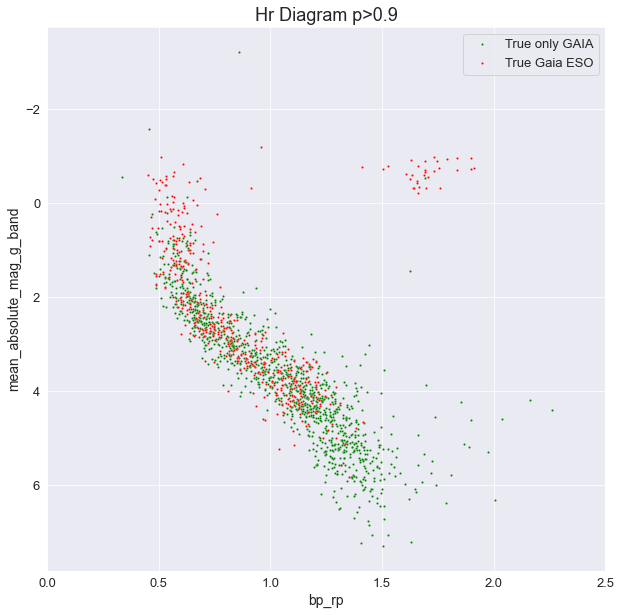

In [72]:

f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=data_for_hr1[data_for_hr1['VRAD']==0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',s=5,color='g')

scatter=data_for_hr1[data_for_hr1['VRAD']!=0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',s=5,color='r')

scatter=data_for_hr2
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Hr Diagram p>0.9")
plt.show()

For the model trained on only GAIA ESO the fit seems to be a little tighter towards the tail still with spread, we check the parameters:

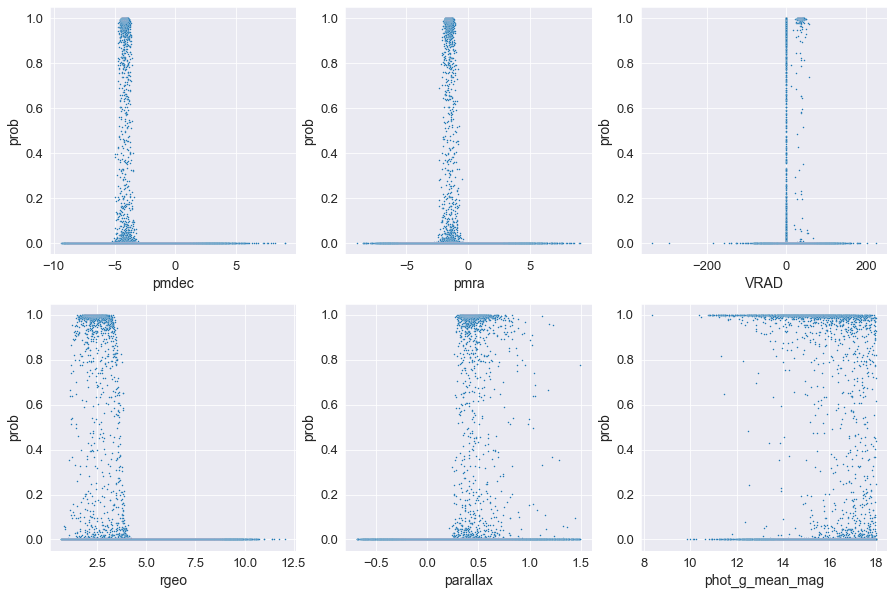

In [73]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

cfplot=df_diagram.sort_values(by='pmdec')
sn.scatterplot(x=cfplot['pmdec'],y=cfplot['prob'],s=2.5,ax=axs[0,0])

cfplot=df_diagram.sort_values(by='pmra')
sn.scatterplot(x=cfplot['pmra'],y=cfplot['prob'],s=2.5,ax=axs[0,1])

cfplot=df_diagram.sort_values(by='VRAD')
sn.scatterplot(x=cfplot['VRAD'],y=cfplot['prob'],s=2.5,ax=axs[0,2])

cfplot=df_diagram.sort_values(by='rgeo')
sn.scatterplot(x=cfplot['rgeo'],y=cfplot['prob'],s=2.5,ax=axs[1,0])

cfplot=df_diagram.sort_values(by='parallax')
sn.scatterplot(x=cfplot['parallax'],y=cfplot['prob'],s=2.5,ax=axs[1,1])

cfplot=df_diagram.sort_values(by='phot_g_mean_mag')
sn.scatterplot(x=cfplot['phot_g_mean_mag'],y=cfplot['prob'],s=2.5,ax=axs[1,2])

plt.show()

This still has significant error finding the distance information, however it is better that what we used to the parallax and we can see it centers around the first peak in the RGEO distribution.

# GAIA + GAIA ESO Train

In [74]:
p=0.9
data_for_hr1_full=df_diagram_full[df_diagram_full['prob']>=p]
data_for_hr2_full=df_diagram_full[df_diagram_full['prob']<p]

We now plot the HR diagram of probabilites using what was trained on all of the data.

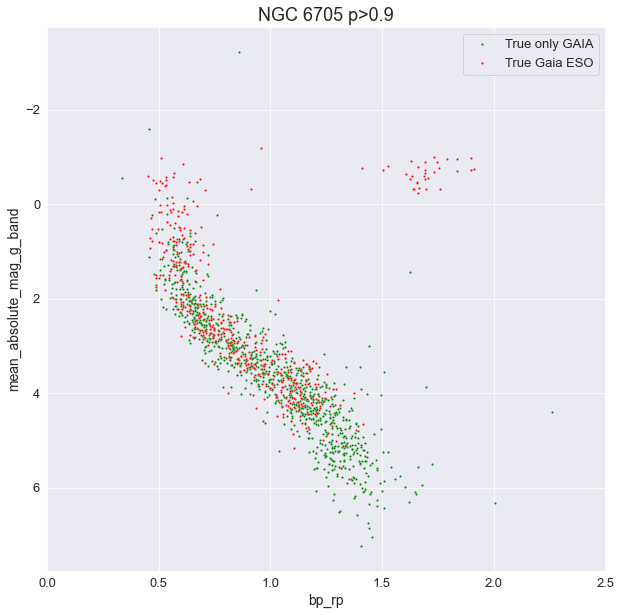

In [75]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=data_for_hr1_full[data_for_hr1_full['VRAD']==0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',s=5,color='g')

scatter=data_for_hr1_full[data_for_hr1_full['VRAD']!=0.00]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',s=5,color='r')

scatter=data_for_hr2_full
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=5,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

See jackson paper for comparison. Using the three component one with all of the data is good.

We now look at what information is found by the probabilities.

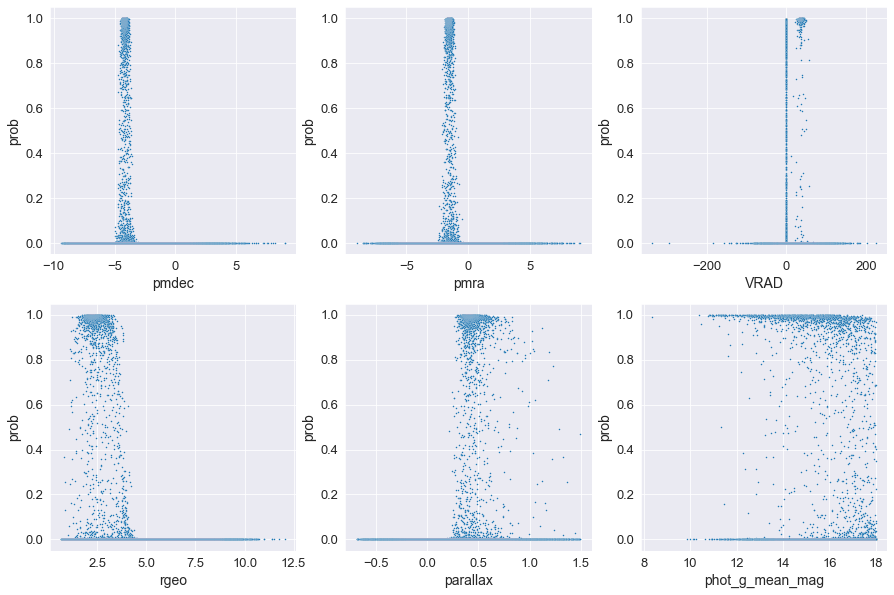

In [76]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

cfplot=df_diagram_full.sort_values(by='pmdec')
sn.scatterplot(x=cfplot['pmdec'],y=cfplot['prob'],s=2.5,ax=axs[0,0])

cfplot=df_diagram_full.sort_values(by='pmra')
sn.scatterplot(x=cfplot['pmra'],y=cfplot['prob'],s=2.5,ax=axs[0,1])

cfplot=df_diagram_full.sort_values(by='VRAD')
sn.scatterplot(x=cfplot['VRAD'],y=cfplot['prob'],s=2.5,ax=axs[0,2])

cfplot=df_diagram_full.sort_values(by='rgeo')
sn.scatterplot(x=cfplot['rgeo'],y=cfplot['prob'],s=2.5,ax=axs[1,0])

cfplot=df_diagram_full.sort_values(by='parallax')
sn.scatterplot(x=cfplot['parallax'],y=cfplot['prob'],s=2.5,ax=axs[1,1])

cfplot=df_diagram_full.sort_values(by='phot_g_mean_mag')
sn.scatterplot(x=cfplot['phot_g_mean_mag'],y=cfplot['prob'],s=2.5,ax=axs[1,2])

plt.show()

Similar analysis to what was trained only on GAIA ESO. To see whats going on lets plot with the distance as the hue:

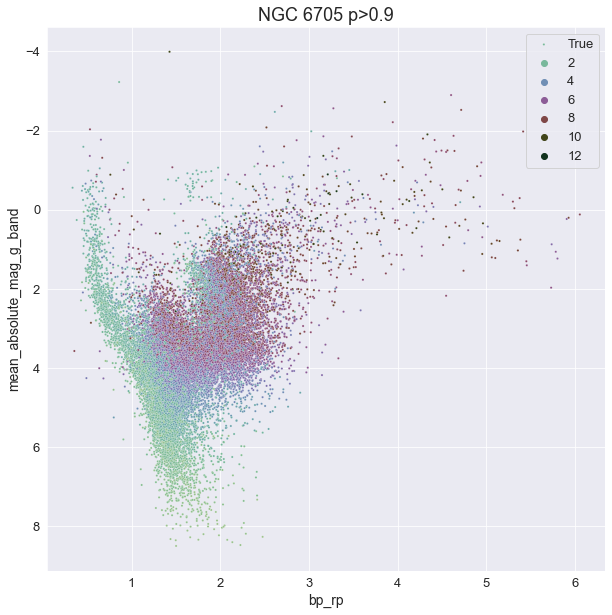

In [77]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=df_diagram#[df_diagram_full['prob']>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],ax=axes,s=5,label='True',palette="ch:r=-2,l=.7")


axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

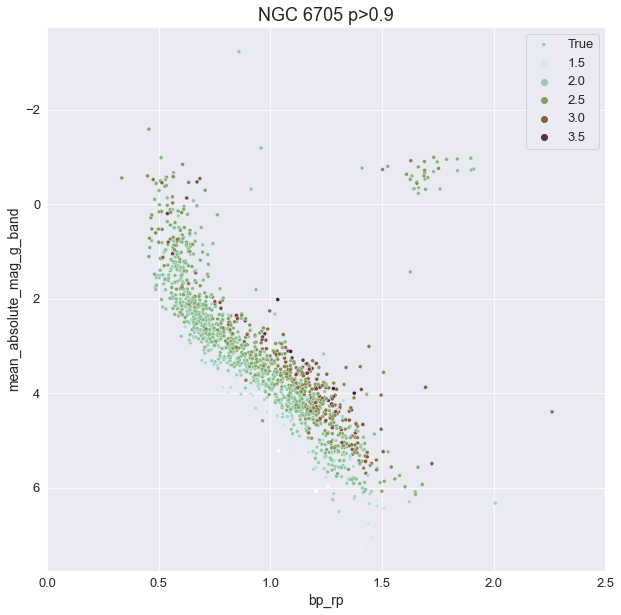

In [78]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=df_diagram_full[df_diagram_full['prob']>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],ax=axes,s=15,label='True',palette='ch:r=1,l=1.0')


axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

And so we can see in here there is significant dispersion on the radial distance.

What percentage of correct data is from GAIA only:

In [79]:
len(data_for_hr1_full[data_for_hr1_full['VRAD']==0.00])/(len(data_for_hr1_full[data_for_hr1_full['VRAD']==0.00])+len(data_for_hr1_full[data_for_hr1_full['VRAD']!=0.00]))

0.6878048780487804

# Let us now check a comparison of the two trained models:

In [80]:
df_diagram_full['prob_other']=df_diagram['prob']

In [81]:
data_for_hr1=df_diagram_full[df_diagram_full['prob']>=0.9]
data_for_hr1both=data_for_hr1[data_for_hr1['prob_other']>=0.9]
data_for_hr2=df_diagram_full[df_diagram_full['prob_other']>=0.9]
data_for_hr2=data_for_hr2[data_for_hr2['prob']<0.9]

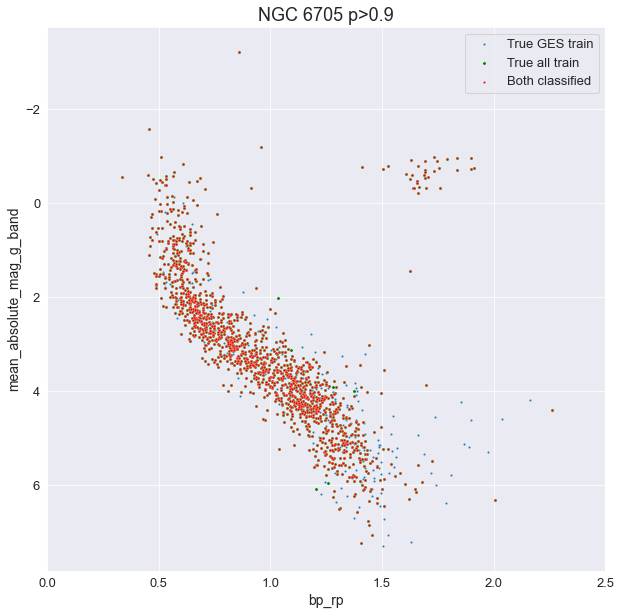

In [82]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)




scatter=data_for_hr2
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True GES train',s=5)

scatter=data_for_hr1
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True all train',color='green')



scatter=data_for_hr1both
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='Both classified',color='r')


axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

# Colour information with normalising FLOW!!!

So page 3 is actually in the SSL Normalising Flow page, however we come back here after.

# Page 3 Full Information

# Try with RGEO instead of Parallax to see if any better.

# Saving FILES

https://arxiv.org/pdf/1405.4895.pdf

Plotting the parameters vs the expected values.

Saving files



In [83]:
data_for_colour=df_diagram_full#[['bp_rp','mean_absolute_mag_g_band','prob','ra','dec','parallax','VRAD','pmra','pmdec','phot_g_mean_mag','bp_g','g_rp','rgeo']]

In [84]:
os.chdir('../cluster_files')
data_for_colour.to_csv('vae_data.csv')


# Normalising Flow Part

In [85]:
os.chdir('../Data_handling')

In [86]:
df_diagram_full['labels']=-1

In [87]:
from sklearn.preprocessing import  MinMaxScaler
import torch
%store -r scaler
scaler=MinMaxScaler()
column_names=['pmra', 'pmdec',
       'rgeo','labels']
#column_names=['ra','dec','pmra','pmdec','mean_absolute_mag_g_band','bp_g','g_rp','bp_rp']
#column_names=['mean_absolute_mag_g_band','bp_rp','ra','dec','rgeo','g_rp','pmra','pmdec','labels']
column_names=['mean_absolute_mag_g_band','bp_rp','bp_g','g_rp','rgeo','labels']  # the rgeo isnt actually used
scaled_data=scaler.fit_transform(df_diagram_full[column_names].fillna(0.5).values)

In [88]:
model=torch.load('model_no_giants2.pt')

In [89]:
model.eval()

FlowGMM(
  (s_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=3, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=2, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=3, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_features=2, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=3, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=25, bias=True)
      (3): ReLU()
      (4): Linear(in_features=25, out_f

# Comments on bringing in the normalising flow

We now want to utilise both the photometric and astrometric data used in the individual training processes to get a joint likelihood. If $\phi _c^a(x), \phi _f^a(x)$ are the astrometric likelihood functions talked about previously, the XDGMM model trained on the full GAIA and GAIA ESO model. Moreover let $\phi _c^p(x), \phi _f^p(x)$ be the likelihood function from the normalising flow on the photometric features of the dataset. We define our full cluster likelihood function to be $\phi _c(x)=\phi _c^p(x)*\phi _c^a(x)$ and similarly with the field likelihood. Then we can define our probability membership exactly as before. 

/Users/mattocallaghan/GES/Data_handling/gmmflow.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)
/Users/mattocallaghan/GES/Data_handling/gmmflow.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


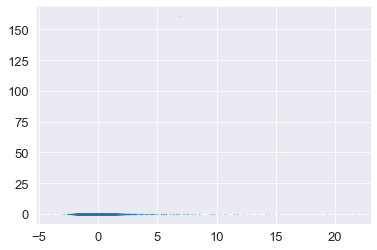

In [90]:
y,gmm,loss,log_l,determinant,ll,det = model(torch.tensor(scaled_data).float())
probs=gmm.class_probs(y).detach().numpy()
y=y.detach().numpy()

plt.scatter(y.transpose()[0],y.transpose()[1],s=0.01)

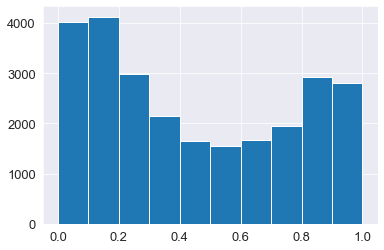

In [91]:
j=0
plt.hist(probs.transpose()[j])
plt.show()


In [92]:
column=[i for i in range(probs.shape[-1])]
df=pd.DataFrame(data=probs,columns=column)
plotdf=pd.concat([df_diagram_full,df],axis=1)

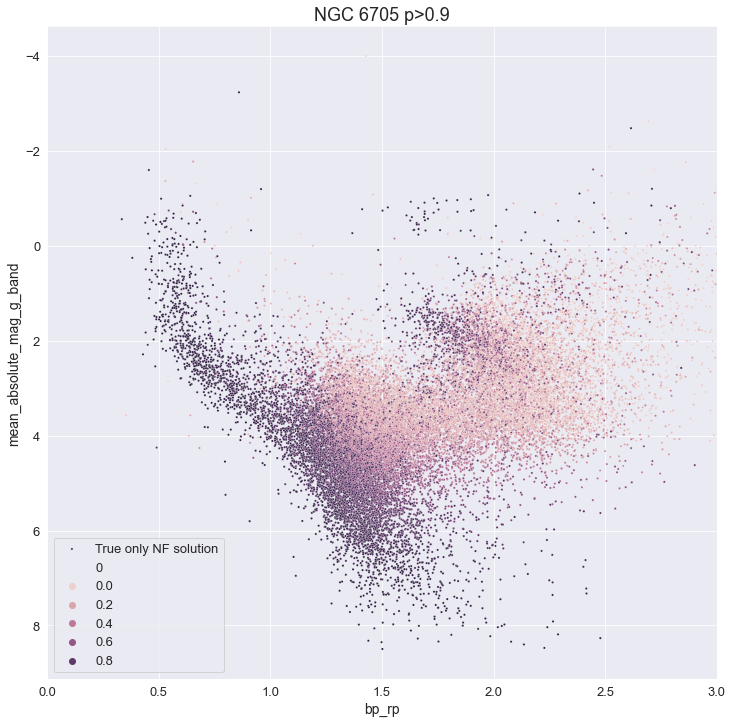

In [93]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=plotdf
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter[j],s=5,ax=axes,label='True only NF solution',color='b')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")


plt.xlim(0,3)
plt.show()


# Now we try the joint probability

In [94]:
from gmmflow import TorchGaussMixture

In [95]:
r = 1.5

x=[-r for i in range(len(column_names)-1)]

yy=[r for i in range(len(column_names)-1)]

z=[(r)*((-1)**i) for i in range(len(column_names)-1)]

means = torch.tensor([x])
meansfalse=torch.tensor([yy,z])
colour_gmm_true=TorchGaussMixture(means=means)
colour_gmm_false=TorchGaussMixture(means=meansfalse)

In [96]:
true_prob=(np.exp(colour_gmm_true.log_prob(torch.tensor(y)).detach().numpy()))
false_prob=(np.exp(colour_gmm_false.log_prob(torch.tensor(y)).detach().numpy()))

/Users/mattocallaghan/GES/Data_handling/gmmflow.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


In [97]:
true_prob.shape

(25832,)

(array([1951., 2552., 2742., 2531., 2117., 1795., 1566., 1590., 2163.,
        6825.]),
 array([0.0000000e+00, 7.6471824e-06, 1.5294365e-05, 2.2941549e-05,
        3.0588730e-05, 3.8235914e-05, 4.5883098e-05, 5.3530279e-05,
        6.1177459e-05, 6.8824644e-05, 7.6471828e-05], dtype=float32),
 <BarContainer object of 10 artists>)

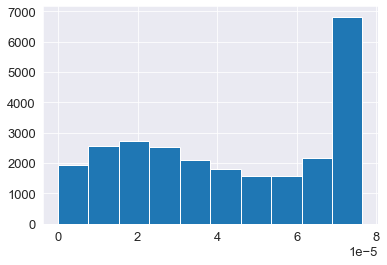

In [98]:
plt.hist(true_prob)

In [99]:
alpha=gmm_full.alpha
mu=gmm_full.mu
V=gmm_full.V


In [100]:
from scipy.stats import multivariate_normal

In [101]:
len(learning_input)-len(scaled_data)

0

In [102]:
final_probability=gmm_full.final_prob(learning_input,Xerr=learning_error_covariance,R=R,prob_true=true_prob,prob_false=false_prob,true_index=prob_index)


/Users/mattocallaghan/GES/Density_estimation/xdeconv.py:361: RuntimeWarning: invalid value encountered in true_divide
  components[:,j]=components[:,j]/sum


# Understand the probability

In [103]:
df=pd.DataFrame(data=final_probability,columns=['p1','p2','p3','p4'])
plotdf_final=pd.concat([plotdf,df],axis=1)

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

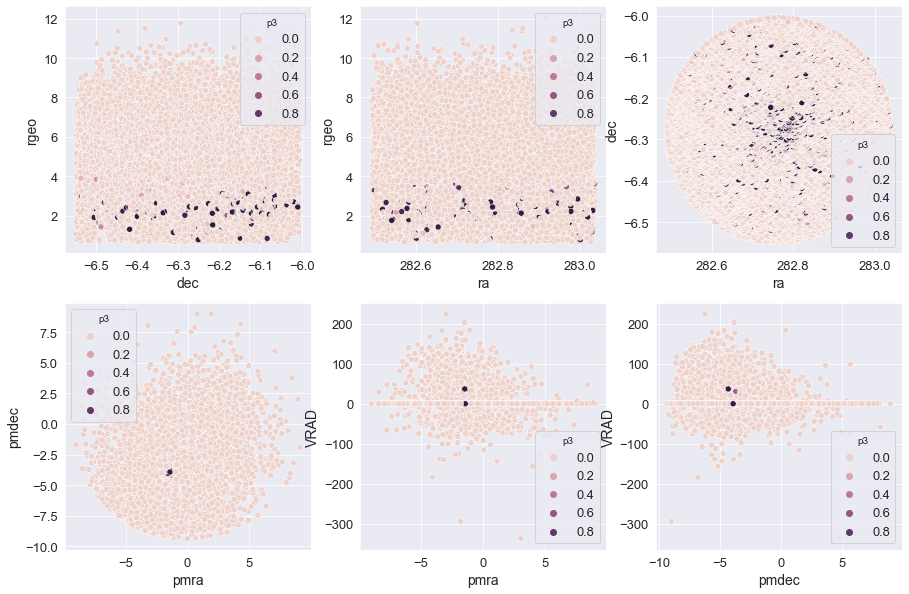

In [123]:
probability='p3'
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plotdf_final,x='dec',y='rgeo',hue=probability,ax=axs[0,0])
sn.scatterplot(data=plotdf_final,x='ra',y='rgeo',hue=probability,ax=axs[0,1])
sn.scatterplot(data=plotdf_final,x='ra',y='dec',hue=probability,ax=axs[0,2])

sn.scatterplot(data=plotdf_final,x='pmra',y='pmdec',hue=probability,ax=axs[1,0])
sn.scatterplot(data=plotdf_final,x='pmra',y='VRAD',hue=probability,ax=axs[1,1])
sn.scatterplot(data=plotdf_final,x='pmdec',y='VRAD',hue=probability,ax=axs[1,2])

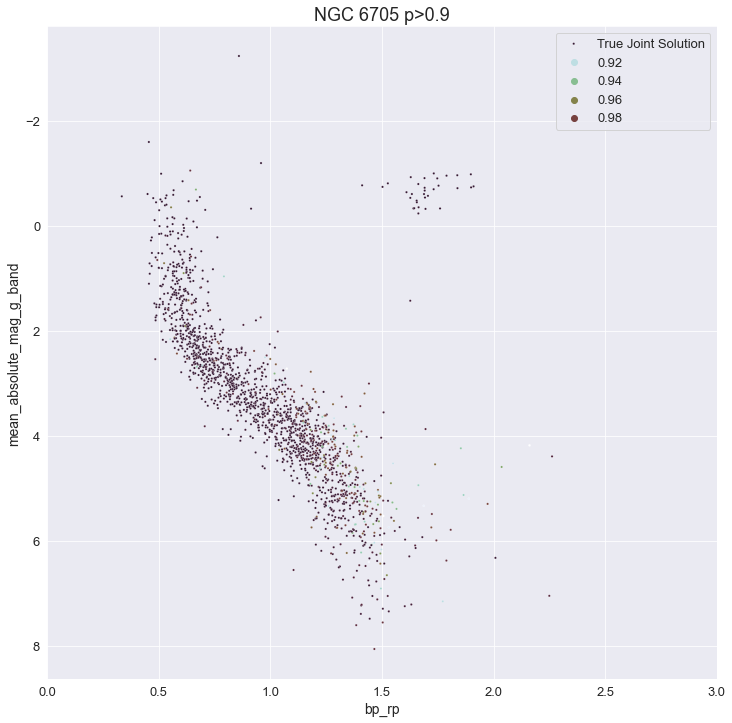

In [124]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=plotdf_final[plotdf_final[probability]>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter[probability],s=5,ax=axes,label='True Joint Solution',color='b', palette="ch:r=1,l=1.0")

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")


plt.xlim(0,3)
plt.show()


# Comments
Here we see that there are much fewer stars classified as being cluster members, however we see that the range of parameters, in particular the radial distance, is consistent with what we expect from an open cluster.

In [125]:
plotdf_final

index          ra       dec      rgeo    VRAD      pmra     pmdec  \
0          0  282.565031 -6.258065  1.942982   30.64  0.776237 -6.756839   
1          1  282.583418 -6.192254  6.141484  105.47 -1.612175 -4.640347   
2          2  282.592885 -6.329504  2.671463   39.07 -2.393408 -4.043109   
3          3  282.596724 -6.241452  1.887643  -43.21 -3.040533 -0.931751   
4          4  282.596739 -6.257442  2.360141   -5.76 -0.711199 -4.404408   
...      ...         ...       ...       ...     ...       ...       ...   
25827  25827  282.788470 -6.007469  7.084011    0.00 -2.850967 -5.665195   
25828  25828  282.780248 -6.007047  2.100936    0.00  1.577184  3.119071   
25829  25829  282.775456 -6.005157  7.769465    0.00 -1.806624 -4.939151   
25830  25830  282.703295 -6.011748  4.963540    0.00 -3.147602 -4.699169   
25831  25831  282.697090 -6.013477  7.083744    0.00 -4.246188 -4.636766   

                prob  level_0  Unnamed: 0  ... mean_absolute_mag_g_band  \
0      1.487105e-106        0           0  ...                 5.377983   
1      1.419702e-106        1           1  ...                 3.868623   
2       4.908982e-05        2           3  ...                 4.753740   
3      7.647293e-279        3           4  ...                 4.844798   
4       1.596731e-46        4           5  ...                 4.017714   
...              ...      ...         ...  ...                      ...   
25827   7.979673e-49    24853      129557  ...                 3.015978   
25828   0.000000e+00    24854      129559  ...                 4.919543   
25829   6.154937e-33    24855      129565  ...                 2.587664   
25830   5.624135e-25    24856      129567  ...                 3.746492   
25831   7.277833e-42    24857      129568  ...                 3.567516   

          prob_other  labels         0         1         2            p1  \
0      7.627518e-103      -1  0.866984  0.074929  0.058087  0.000000e+00   
1      3.514835e-102      -1  0.204259  0.325964  0.469777  0.000000e+00   
2       3.729123e-04      -1  0.786455  0.112842  0.100703  0.000000e+00   
3      1.637330e-247      -1  0.864293  0.076247  0.059460  0.000000e+00   
4       3.281928e-39      -1  0.844644  0.085656  0.069700  3.477735e-35   
...              ...     ...       ...       ...       ...           ...   
25827   1.263810e-62      -1  0.119520  0.338371  0.542110  1.919676e-02   
25828   0.000000e+00      -1  0.802627  0.105412  0.091961  6.899576e-04   
25829   1.139143e-51      -1  0.006661  0.324521  0.668818  1.257328e-02   
25830   6.184649e-29      -1  0.366628  0.281487  0.351885  3.002892e-02   
25831   2.559230e-57      -1  0.041155  0.349699  0.609147  1.349001e-01   

                 p2             p3        p4  
0      9.981640e-01  1.938561e-105  0.001836  
1      6.309017e-05  7.288482e-107  0.999937  
2      6.351958e-01   3.614678e-04  0.364443  
3      9.927772e-01  9.740819e-278  0.007223  
4      8.086313e-01   1.736237e-45  0.191369  
...             ...            ...       ...  
25827  2.739833e-07   2.166384e-49  0.980803  
25828  9.916512e-01   0.000000e+00  0.007659  
25829  7.546910e-09   8.254694e-35  0.987427  
25830  5.065184e-03   6.511077e-25  0.964906  
25831  1.419554e-06   6.247479e-43  0.865098  

[25832 rows x 203 columns]

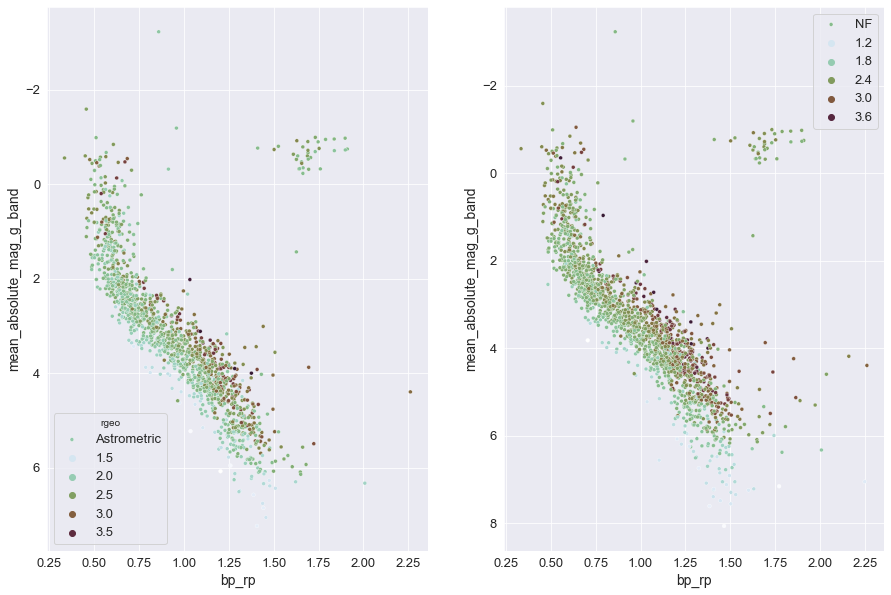

In [126]:
f, axes = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(15)


scatter=df_diagram_full[df_diagram_full['prob']>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],ax=axes[0],s=15,label='Astrometric',palette='ch:r=1,l=1.0')




scatter=plotdf_final[plotdf_final[probability]>0.9]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes[1],hue=scatter['rgeo'],label='NF',s=15,palette="ch:r=1,l=1.0")



axes[0].invert_yaxis()
axes[1].invert_yaxis()
plt.legend()
plt.show()

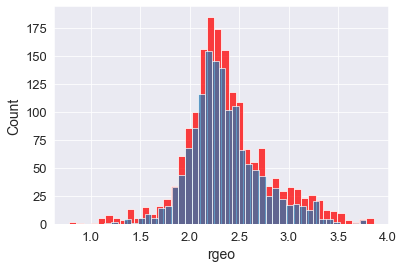

In [127]:
sn.histplot(plotdf_final[plotdf_final[probability]>0.9]['rgeo'],color='r')
sn.histplot(df_diagram_full[df_diagram_full['prob']>0.9]['rgeo'],alpha=0.7)

plt.show()

In [128]:
len(scatter)/(len(plotdf_final[plotdf_final['prob']>0.9])+len(scatter))

0.5505793924209208

# Only 15 percent in the original classification but hast the distance relation

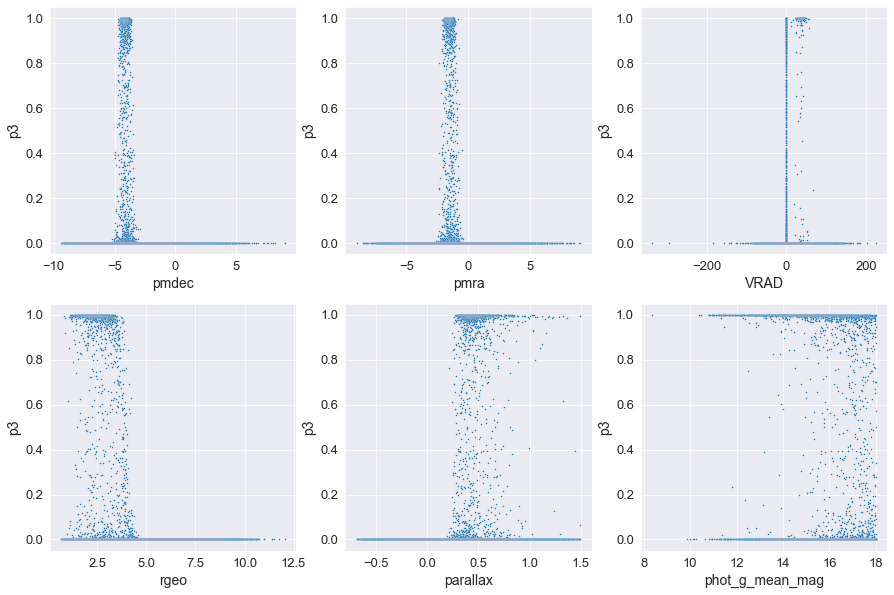

In [129]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

cfplot=plotdf_final.sort_values(by='pmdec')
sn.scatterplot(x=cfplot['pmdec'],y=cfplot[probability],s=2.5,ax=axs[0,0])

cfplot=plotdf_final.sort_values(by='pmra')
sn.scatterplot(x=cfplot['pmra'],y=cfplot[probability],s=2.5,ax=axs[0,1])

cfplot=plotdf_final.sort_values(by='VRAD')
sn.scatterplot(x=cfplot['VRAD'],y=cfplot[probability],s=2.5,ax=axs[0,2])

cfplot=plotdf_final.sort_values(by='rgeo')
sn.scatterplot(x=cfplot['rgeo'],y=cfplot[probability],s=2.5,ax=axs[1,0])

cfplot=plotdf_final.sort_values(by='parallax')
sn.scatterplot(x=cfplot['parallax'],y=cfplot[probability],s=2.5,ax=axs[1,1])

cfplot=plotdf_final.sort_values(by='phot_g_mean_mag')
sn.scatterplot(x=cfplot['phot_g_mean_mag'],y=cfplot[probability],s=2.5,ax=axs[1,2])

plt.show()

In [130]:
data_for_hr1=plotdf_final[plotdf_final[probability]>=0.9]
data_for_hr1both=plotdf_final[plotdf_final['prob']>=0.9]
data_for_hr2=plotdf_final[plotdf_final['prob']>=0.9]
data_for_hr2=data_for_hr2[data_for_hr2[probability]<0.9]

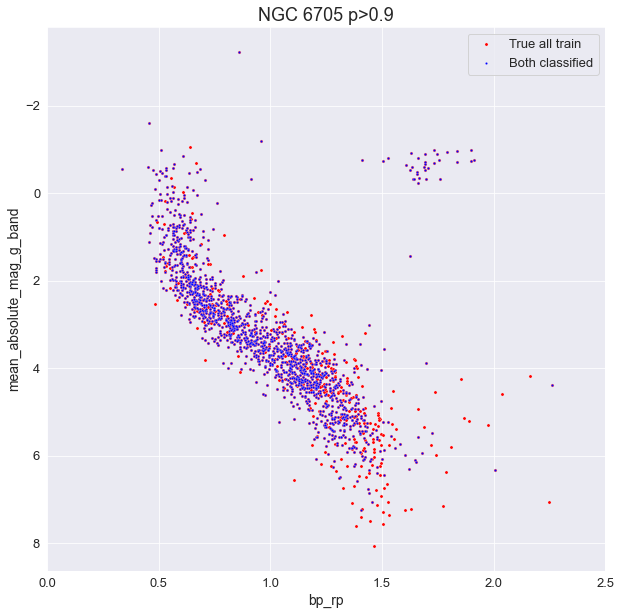

In [131]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)




scatter=data_for_hr2
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Only Original ',s=5)

scatter=data_for_hr1
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True all train',color='r')



scatter=data_for_hr1both
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='Both classified',color='b')


axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

Thus this gives us a logical membership probability for the cluster members which seems to be reasonable.

In [132]:
x=plotdf_final[plotdf_final['prob']>0.9]
y=plotdf_final[plotdf_final[probability]>0.9]

In [133]:
y=y[y['rgeo']>2.0].reset_index(drop=True)
y=y[y['rgeo']<2.7].reset_index(drop=True)
x=x[x['rgeo']>2.0].reset_index(drop=True)
x=x[x['rgeo']<2.7].reset_index(drop=True)

In [134]:
len(y)/(len(x))

1.127536231884058

In [135]:
x=x[x[probability]<0.9]

So we can see there is still a lot of stars at that distance, but lets check their parameters.

In [136]:
y=plotdf_final[plotdf_final[probability]>=0.9]

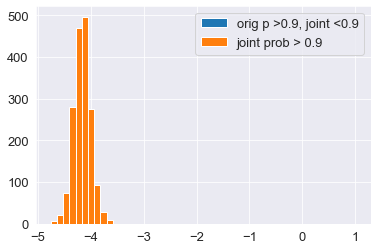

In [137]:
plt.hist(x['pmdec'],label='orig p >0.9, joint <0.9')
plt.hist(y['pmdec'],label='joint prob > 0.9')
plt.legend()
plt.show()

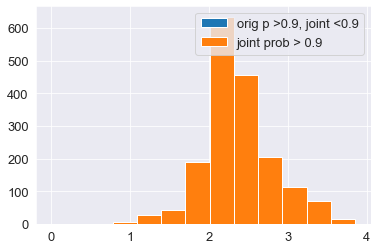

In [138]:
plt.hist(x['rgeo'],label='orig p >0.9, joint <0.9',bins=100)
plt.hist(y['rgeo'],label='joint prob > 0.9')
plt.legend()
plt.show()

In [139]:
x=x[x['rgeo']<2.6].reset_index(drop=True)
x=x[x['rgeo']>2.0].reset_index(drop=True)

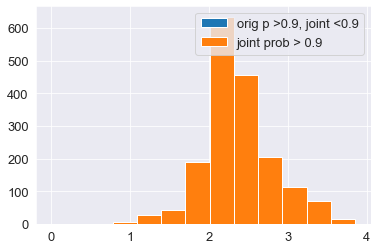

In [140]:
plt.hist(x['rgeo'],label='orig p >0.9, joint <0.9')
plt.hist(y['rgeo'],label='joint prob > 0.9')
plt.legend()
plt.show()

Still a bit more of a spread, check the other parameters.

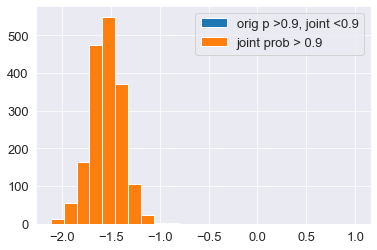

In [141]:
plt.hist(x['pmra'],label='orig p >0.9, joint <0.9')
plt.hist(y['pmra'],label='joint prob > 0.9')
plt.legend()
plt.show()

# A lot of these are potential candidates that we have missed

In [142]:
os.getcwd()

'/Users/mattocallaghan/GES/Data_handling'

In [143]:
os.chdir('../Parameter_files')

In [144]:
plotdf_final.to_csv('cluster_members_final.csv')